In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import glob
import gc
import copy

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )   

    def forward(self, x): 
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x): 
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )   

    def forward(self, x): 
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x        
        
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, nc=16):
        super(UNet, self).__init__()
        self.nc = nc
        self.inc = inconv(n_channels, nc) 
        self.down1 = down(nc, nc*2)
        self.down2 = down(nc*2, nc*4)
        self.down3 = down(nc*4, nc*8)
        self.down4 = down(nc*8, nc*8)
        self.up1 = up(nc*16, nc*4)
        self.up2 = up(nc*8, nc*2)
        self.up3 = up(nc*4, nc) 
        self.up4 = up(nc*2, nc) 
        self.outc = outconv(nc, n_classes)

    def forward(self, x): 
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4) 
        x = self.up2(x, x3) 
        x = self.up3(x, x2) 
        x = self.up4(x, x1) 
        x = self.outc(x)
        return F.sigmoid(x)

In [3]:
class segmentation_dataset(Dataset):
    
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None, in_memory=True):  
        
        assert(len(image_paths) == len(mask_paths))
        
        self.transform = transform
        self.mask_transform = mask_transform
        self.len = len(image_paths)
        self.in_memory = in_memory
        
        if not self.in_memory:
            self.image_paths = image_paths
            self.mask_paths = mask_paths
            return
        
        self.image = []
        self.mask = []

        for image_path, mask_path in tqdm(zip(image_paths, mask_paths)):
            
            image = io.imread(image_path)
            mask = io.imread(mask_path)
            
            if (len(image.shape)!=3):
                continue
            
            if self.transform is not None:
                image = self.transform(image)
            self.image.append(image)
            
            if self.mask_transform is not None:
                mask = self.mask_transform(np.expand_dims(mask,axis=-1))
            self.mask.append(mask)
            
        self.len = len(self.image)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        if self.in_memory:
            return self.image[idx], self.mask[idx]
        else:
            image_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]
            image = io.imread(image_path)
            mask = io.imread(mask_path)
            if self.transform is not None:
                image = self.transform(image)
            if self.mask_transform is not None:
                mask = self.mask_transform(np.expand_dims(mask,axis=-1))
            return image, mask

In [4]:
image_paths = sorted(glob.glob("segmentation/image64/*.jpg"))
mask_paths = sorted(glob.glob("segmentation/mask64/*.jpg"))
dataset = segmentation_dataset(image_paths, mask_paths,
                               transform = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                               mask_transform = transforms.ToTensor(),
                               in_memory=False)
#dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)

In [5]:
val_size = 0.05
p = np.random.rand(len(dataset))
train_idx = np.where(p>val_size)[0]
val_idx = np.where(p<=val_size)[0]
trainset = Subset(dataset, train_idx)
valset = Subset(dataset, val_idx)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=1)
val_loader = DataLoader(valset, batch_size=128, shuffle=True, num_workers=1)

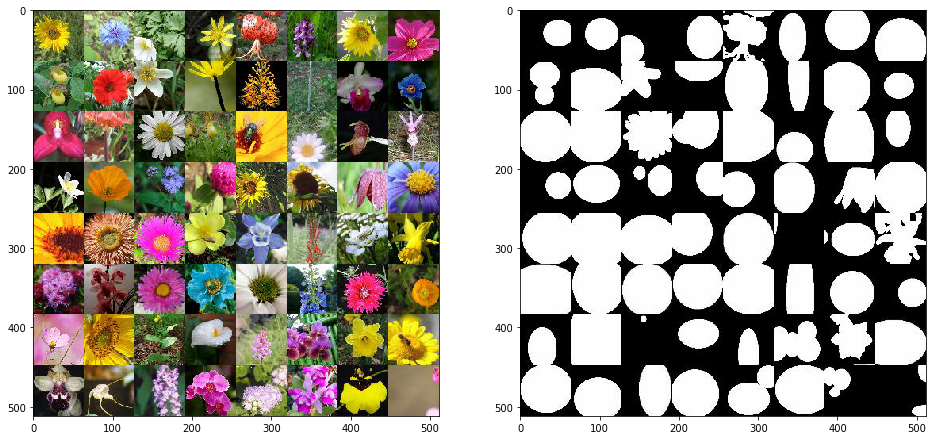

In [6]:
# Plot some training images
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
batch = next(iter(train_loader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))

In [7]:
def train(train_loader, val_loader=None, model=None, epoch=1, optimizer=None, criterion=None, early_stopping=3, device=device):
        
    best_loss = 10000000
    best_epoch = 0
    best_model_wts = None
    
    for t in range(epoch):
        
        model.train()
        
        for i_batch, batch in tqdm(enumerate(train_loader)):
            
            batch_X, batch_y = batch[0].to(device), batch[1].to(device)
            batch_y_pred = model(batch_X)
            loss = criterion(batch_y_pred.view(-1), batch_y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if val_loader is not None: #evaluate on validation data
            
            model.eval()
            running_loss = 0.0
            with torch.no_grad():
                for i_batch, batch in enumerate(val_loader):
                    batch_X, batch_y = batch[0].to(device), batch[1].to(device)
                    batch_y_pred = model(batch_X)
                    loss = criterion(batch_y_pred.view(-1), batch_y.view(-1))                   
                    running_loss += loss.item() * batch_X.size()[0]
        
            epoch_loss = running_loss / len(val_loader.dataset)
            print ("epoch %d, loss %.6f"%(t, epoch_loss))
            
            if epoch_loss < best_loss: #keep track of best loss and epoch
                best_loss = epoch_loss
                best_epoch = t
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if (t - best_epoch > early_stopping): #early stopping if loss haven't improve for n=early_stopping rounds
                break
                
    if best_model_wts is not None:
        print("load best weights from epoch %d"%best_epoch)
        model.load_state_dict(best_model_wts)
        
        
def predict(predictions, dataloader, model):
    
    N = len(dataloader.dataset)
    n_batches = len(dataloader)
    batch_size = dataloader.batch_size
    
    model.eval()
    with torch.no_grad():
        for i_batch, batch in tqdm(enumerate(dataloader)):
            batch_X, batch_y = batch[0].to(device), batch[1].to(device)
            batch_y_pred = model(batch_X)
                
            start = i_batch * batch_size
            end = start + batch_size
            if i_batch == n_batches - 1:
                end = N
            predictions[start:end] = batch_y_pred   
                
    return predictions

In [8]:
net = UNet(n_channels=3, n_classes=1).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    net = nn.DataParallel(net, list(range(ngpu)))

optimizer = optim.SGD(net.parameters(),
                      lr=0.001,
                      momentum=0.9,
                      weight_decay=0.0005)

criterion = nn.BCELoss()
train(train_loader, val_loader, model=net, epoch=10, optimizer=optimizer, criterion=criterion, early_stopping=3)

!mkdir model_checkpoints
torch.save({
            'model_dict': net.state_dict(),
            'optimizer_dict': optimizer.state_dict()
            }, "model_checkpoints/unet")

0it [00:00, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
204it [02:38,  1.28it/s]


epoch 0, loss 0.571811


204it [01:05,  3.12it/s]


epoch 1, loss 0.490687


204it [00:56,  3.59it/s]


epoch 2, loss 0.443240
load best weights from epoch 2


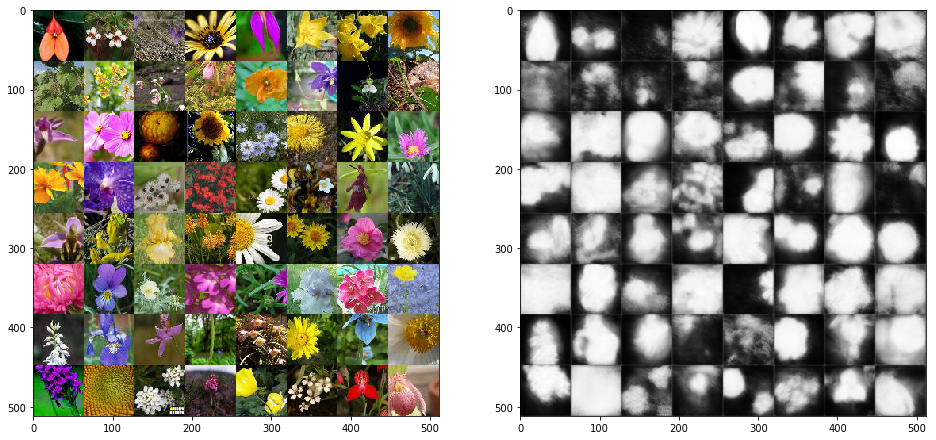

In [22]:
batch = next(iter(val_loader))
pred_masks = net(batch[0].to(device)).detach()
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(vutils.make_grid(pred_masks.to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))